In [1]:
import pandas as pd
import torch
import numpy as np

# LRAP. Instance-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LRAP(preds, labels):
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = (scores.sum(-1) / labels.sum(-1)).mean()
    return score.item()

# label-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LWLRAP(preds, labels):
    preds = preds.to('cpu')
    labels = labels.to('cpu')

    labels[labels > 0.0] = 1.0  # label smoothingする場合もスコア計算のため1にしてしまう
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    # Number of GT labels per instance
    # num_labels = labels.sum(-1)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = scores.sum() / labels.sum()
    return score.item()

In [3]:

input_dir = "../oof/"
oof = pd.read_csv(input_dir + "fold0_oof.csv")
# oof1 = pd.read_csv(input_dir + "fold1_oof.csv")
# oof2 = pd.read_csv(input_dir + "fold2_oof.csv")
# oof3 = pd.read_csv(input_dir + "fold3_oof.csv")
# oof4 = pd.read_csv(input_dir + "fold4_oof.csv")
# oof = pd.concat([oof0, oof1, oof2, oof3, oof4])
oof

,patch,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,0,003bec244,0.398762,0.735529,0.428103,0.524817,0.458391,0.453542,0.432568,0.682348,...,0.542786,0.450903,0.485308,0.412199,0.418592,0.445328,0.456194,0.425074,0.341329,0.446404
1,1,003bec244,0.394883,0.481696,0.428322,0.640915,0.433360,0.446686,0.462121,0.540128,...,0.542686,0.466853,0.445528,0.410884,0.435581,0.444923,0.449402,0.448831,0.418277,0.458335
2,2,003bec244,0.349760,0.456614,0.417691,0.591700,0.457110,0.410183,0.440069,0.826130,...,0.610566,0.474064,0.460986,0.398166,0.415457,0.431743,0.467821,0.407540,0.415869,0.384644
3,3,003bec244,0.412226,0.468707,0.416773,0.549272,0.366584,0.402851,0.468874,0.598235,...,0.572506,0.451019,0.461097,0.399223,0.433492,0.457825,0.471497,0.393162,0.398850,0.417720
4,4,003bec244,0.389579,0.457444,0.427811,0.493934,0.348904,0.428539,0.446324,0.544494,...,0.634886,0.498574,0.441636,0.421461,0.386579,0.449515,0.475173,0.425653,0.489935,0.429711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7547,3,ffc6031f8,0.313460,0.448482,0.391829,0.749874,0.378695,0.377572,0.430460,0.954595,...,0.482239,0.433942,0.457888,0.399898,0.411008,0.442472,0.411287,0.357527,0.322628,0.340093
7548,4,ffc6031f8,0.281973,0.421260,0.415486,0.628940,0.348745,0.402714,0.430003,0.904457,...,0.466157,0.829329,0.454781,0.396127,0.469426,0.457667,0.413845,0.324086,0.276281,0.403346
7549,5,ffc6031f8,0.311228,0.426034,0.446159,0.525393,0.333149,0.422979,0.443885,0.853659,...,0.487556,0.825624,0.450244,0.388145,0.467176,0.468811,0.434239,0.387309,0.329812,0.438557
7550,6,ffc6031f8,0.363061,0.459935,0.435258,0.800537,0.413529,0.419935,0.430754,0.829262,...,0.472171,0.444567,0.464678,0.416836,0.428104,0.434627,0.431353,0.398803,0.355111,0.396602


In [4]:
oof2 = oof.groupby('recording_id').max().reset_index(drop=False)
oof2

,recording_id,patch,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,003bec244,7,0.412226,0.735529,0.432691,0.640915,0.458391,0.453542,0.470479,0.826130,...,0.641557,0.498574,0.485308,0.421461,0.435581,0.457825,0.521423,0.448831,0.489935,0.489930
1,005f1f9a5,7,0.434775,0.829225,0.440830,0.801901,0.429966,0.458336,0.442409,0.861068,...,0.540540,0.474423,0.468865,0.464170,0.451558,0.453582,0.454205,0.472928,0.404084,0.466147
2,009aa1c8f,7,0.389176,0.425608,0.441691,0.683870,0.457826,0.447137,0.434561,0.537896,...,0.496090,0.484258,0.426744,0.416365,0.891755,0.449652,0.439243,0.511412,0.382900,0.442326
3,00ad36516,7,0.939850,0.422735,0.440206,0.620777,0.450451,0.442869,0.443069,0.518529,...,0.504983,0.418105,0.442395,0.414393,0.906784,0.422080,0.431908,0.466080,0.415799,0.444663
4,00d442df7,7,0.937391,0.389712,0.438265,0.565592,0.442325,0.421982,0.441543,0.528704,...,0.436010,0.420344,0.458261,0.447224,0.917958,0.400908,0.446008,0.464050,0.389740,0.439705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,ff56888a1,7,0.397557,0.469489,0.440119,0.516086,0.476269,0.449866,0.434171,0.901203,...,0.483483,0.538415,0.473744,0.439884,0.433200,0.464937,0.448993,0.475487,0.415134,0.449890
940,ff6acf404,7,0.401710,0.517897,0.441469,0.528072,0.466516,0.453345,0.431434,0.632564,...,0.484439,0.472330,0.453184,0.441970,0.452308,0.447559,0.452684,0.491552,0.369433,0.464048
941,ff858780b,7,0.396295,0.448424,0.450516,0.764075,0.408176,0.452635,0.447680,0.529033,...,0.458049,0.507934,0.555631,0.453104,0.460014,0.441688,0.456972,0.413493,0.437579,0.444214
942,ffb8d8391,7,0.414999,0.498053,0.445012,0.843274,0.453847,0.703018,0.455419,0.526107,...,0.475652,0.465718,0.473042,0.439967,0.680162,0.454355,0.454225,0.464715,0.424295,0.466037


In [21]:
tp_oof = oof2[oof2['recording_id'].isin(tp2['recording_id'])].reset_index(drop=True).sort_values('recording_id')
tp_oof

,recording_id,patch,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,003bec244,7,0.412226,0.735529,0.432691,0.640915,0.458391,0.453542,0.470479,0.826130,...,0.641557,0.498574,0.485308,0.421461,0.435581,0.457825,0.521423,0.448831,0.489935,0.489930
1,00d442df7,7,0.937391,0.389712,0.438265,0.565592,0.442325,0.421982,0.441543,0.528704,...,0.436010,0.420344,0.458261,0.447224,0.917958,0.400908,0.446008,0.464050,0.389740,0.439705
2,0275e127d,7,0.430878,0.449197,0.428510,0.579071,0.381663,0.439667,0.497176,0.506813,...,0.378376,0.443497,0.433554,0.569627,0.483298,0.458210,0.490271,0.364377,0.374726,0.431382
3,0295e3234,7,0.395970,0.434315,0.443314,0.570025,0.391342,0.491252,0.491981,0.577873,...,0.468664,0.867033,0.455383,0.453805,0.475637,0.490959,0.541751,0.411729,0.413198,0.887783
4,03d77fede,7,0.923145,0.399772,0.447351,0.690227,0.466360,0.440262,0.445056,0.528162,...,0.470584,0.425233,0.436951,0.409635,0.903312,0.445387,0.433686,0.506244,0.417045,0.446413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,fc6609050,7,0.931611,0.427007,0.436710,0.586074,0.470738,0.424197,0.434461,0.542991,...,0.482250,0.423115,0.444977,0.383832,0.877951,0.409061,0.430103,0.465813,0.334203,0.443783
221,fd3f0d49b,7,0.401164,0.461410,0.439599,0.514056,0.465209,0.448442,0.898446,0.850390,...,0.502781,0.601141,0.467151,0.445415,0.439422,0.456947,0.478833,0.472604,0.394190,0.449391
222,fd6a520d8,7,0.465236,0.522644,0.448432,0.569444,0.429420,0.455672,0.466737,0.514914,...,0.585499,0.508834,0.515500,0.440550,0.595795,0.464189,0.473979,0.483246,0.508431,0.460437
223,fdda158ed,7,0.506061,0.429552,0.486171,0.787032,0.517274,0.473593,0.432312,0.556406,...,0.494372,0.465224,0.535892,0.412804,0.772447,0.417116,0.447050,0.461329,0.491259,0.464743


In [20]:
tp = pd.read_csv("../input/rfcx-species-audio-detection/train_tp.csv")
tp_fnames, tp_labels = [], []
for recording_id, df in tp.groupby("recording_id"):
    v = sum([np.eye(24)[i] for i in df["species_id"].tolist()])
    v = (v >= 1).astype(int).tolist()
    tp_fnames.append(recording_id)
    tp_labels.append(v) 

tp2 = pd.DataFrame(tp_labels, columns=[f's{i}' for i in range(24)])
tp2['recording_id'] = tp_fnames
tp2 = tp2.sort_values('recording_id')
tp2


,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s15,s16,s17,s18,s19,s20,s21,s22,s23,recording_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,003bec244
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,006ab765f
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,007f87ba2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0099c367b
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,009b760e6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fe8d9ac40
1128,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fea6b438a
1129,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ff2eb9ce5
1130,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ffb8d8391


In [22]:
tp2 = tp2[tp2["recording_id"].isin(tp_oof["recording_id"])]

In [23]:
pred = tp_oof.loc[:, 's0':'s23'].values
target = tp2.loc[:, 's0':'s23'].values

In [24]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
auc = roc_auc_score(target, pred, average=None)
auc

array([0.99534884, 0.98046512, 0.91552511, 0.80093023, 0.97209302,
       0.98232558, 1.        , 0.93255814, 0.96837209, 0.99803408,
       0.99897119, 0.96604651, 0.98651163, 1.        , 0.99162791,
       0.97395349, 1.        , 0.9944186 , 0.95023256, 1.        ,
       1.        , 0.97767442, 0.99382716, 0.98577563])

<BarContainer object of 24 artists>

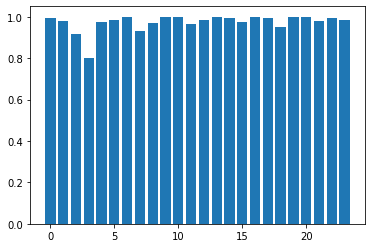

In [25]:
plt.bar(np.arange(24), auc)

In [26]:
pred = torch.tensor(pred)
target = torch.tensor(target)
pred.shape, target.shape

(torch.Size([225, 24]), torch.Size([225, 24]))

In [27]:
original_lwlrap = LWLRAP(pred, target)
original_lwlrap

0.8294745683670044